In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# The following code is for random generation of colors.
# See here: https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    np.random.seed(seed=10)
    np.random.RandomState(seed=10)

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/ppi_mips.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/ppi_mips.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_ppi_mips', ref_nodes) 
            np.save('results/info_ref_nodes_ppi_mips', info_ref_nodes) 
        else:
            continue
        
    number_feature += 1

Reached
Number of feature 0 Feature value  18.0  gap  [0.91102714]  volume:  108.0  size: 9 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  28.0  gap  [0.94477965]  volume:  1861.0  size: 33 conductance:  0.4325631380977969
Reached
Number of feature 0 Feature value  34.0  gap  [0.91197756]  volume:  135.0  size: 10 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  62.0  gap  [0.95170591]  volume:  103.0  size: 8 conductance:  0.4563106796116505
Reached
Number of feature 0 Feature value  63.0  gap  [0.91102714]  volume:  108.0  size: 9 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  80.0  gap  [0.91275576]  volume:  165.0  size: 11 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  82.0  gap  [0.91787315]  volume:  1488.0  size: 32 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  87.0  gap  [0.91483327]  volume:  315.0  size: 15 conductance:  0.3333333333

## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_ppi_mips.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_ppi_mips.npy') 

## Visualize the ground truth clusters

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
    
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("vector<double>")

c_map = rand_cmap(n, type='bright', first_color_black=False, last_color_black=False, verbose=False)

for i in range(n):
    node_colours[i] = [0,0,0]

counter = 0

for i in ref_nodes:
    
    for j in i:
        node_colours[j] = c_map(int(info_ref_nodes[counter,1]))
    counter += 1

#def get_cmap(n, name='hsv'):
#    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#    RGB color; the keyword argument name must be a standard mpl colormap name.'''
#    return plt.cm.get_cmap(name, n)

#c_map = get_cmap(g_gtool.num_vertices())

#c_map = rand_cmap(n, type='bright', first_color_black=True, last_color_black=False, verbose=True)

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           #vcmap = c_map
           output='ppi_mips_selected.png'
          )

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13a1f27b8, at 0x13a1e8fd0>

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:
            
            rho = 0.2/sum(g.d[rr])

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=rho,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_ppi_mips', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_ppi_mips', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_ppi_mips', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_ppi_mips', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_ppi_mips', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_ppi_mips', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_ppi_mips', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_ppi_mips', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_ppi_mips', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_ppi_mips', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_ppi_mips', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_ppi_mips', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_ppi_mips', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_ppi_mips', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_ppi_mips', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_ppi_mips', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_ppi_mips', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_ppi_mips', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_ppi_mips', cuts_acl_ALL) 
    
    np.save('results/nodes_ppi_mips', nodes)

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.25  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  809  completed:  0.75  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  376  completed:  0.0  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  374  completed:  0.0625  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  362  completed:  0.125  degree:  51.0
conductance:  0.3333333333333333 f1sco

/usr/local/lib/python3.7/site-packages/localgraphclustering/spectral_clustering.py:95: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.

/usr/local/lib/python3.7/site-packages/localgraphclustering/approximate_PageRank.py:110: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.



outer: 1 number of node:  375  completed:  0.375  degree:  38.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  346  completed:  0.4375  degree:  67.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  368  completed:  0.5  degree:  45.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  357  completed:  0.5625  degree:  56.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  343  completed:  0.625  degree:  70.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  354  completed:  0.6875  degree:  59.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.882408724

outer: 9 number of node:  848  completed:  0.16666666666666666  degree:  36.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  852  completed:  0.25  degree:  32.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  846  completed:  0.3333333333333333  degree:  38.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  843  completed:  0.4166666666666667  degree:  41.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  837  completed:  0.5  degree:  47.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  851  completed:  0.5833333333333334  degree:  33.0
conductance:  0.3370165745856354 f1s

4
outer: 16 number of node:  799  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  797  completed:  0.25  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  798  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  794  completed:  0.75  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
40
outer: 17 number of node:  77  completed:  0.0  degree:  145.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  67  completed:  0.025  degree:  155.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  99  completed:  0.05  degree:  123.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number 

outer: 18 number of node:  55  completed:  0.6428571428571429  degree:  58.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  32  completed:  0.6785714285714286  degree:  81.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  4  completed:  0.7142857142857143  degree:  109.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  30  completed:  0.75  degree:  83.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  53  completed:  0.7857142857142857  degree:  60.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  27  completed:  0.8214285714285714  degree:  86.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  57  completed:  0.8571428571428571  degree:  56.0
conductance:  0.333

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.25  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  809  completed:  0.75  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  376  completed:  0.0  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  374  completed:  0.0625  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  362  completed:  0.125  degree:  51.0
conductance:  0.3333333333333333 f1sco

/usr/local/lib/python3.7/site-packages/localgraphclustering/flow_clustering.py:46: UserWarning:

The weights of the graph will be discarded. Use "crd" if you want to keep them.



4
outer: 4 number of node:  273  completed:  0.0  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 4 number of node:  272  completed:  0.25  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 4 number of node:  274  completed:  0.5  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 4 number of node:  277  completed:  0.75  degree:  8.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
5
outer: 5 number of node:  724  completed:  0.0  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 5 number of node:  725  completed:  0.2  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 5 number of node:  719  completed:  0.4  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 5 number of node:  718

outer: 12 number of node:  922  completed:  0.7142857142857143  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 12 number of node:  912  completed:  0.8571428571428571  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
7
outer: 13 number of node:  872  completed:  0.0  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  868  completed:  0.14285714285714285  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  873  completed:  0.2857142857142857  degree:  19.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  866  completed:  0.42857142857142855  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  871  completed:  0.5714285714285714  degree:  21.0
conductan

outer: 18 number of node:  42  completed:  0.2857142857142857  degree:  71.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  19  completed:  0.32142857142857145  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  54  completed:  0.35714285714285715  degree:  59.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  7  completed:  0.39285714285714285  degree:  106.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  22  completed:  0.42857142857142855  degree:  91.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  31  completed:  0.4642857142857143  degree:  82.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  10  completed:  0.5  degree:  103.0
conductance:  0

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0.00000000001)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.25  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  809  completed:  0.75  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  376  completed:  0.0  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  374  completed:  0.0625  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  362  completed:  0.125  degree:  51.0
conductance:  0.3333333333333333 f1sco

/usr/local/lib/python3.7/site-packages/localgraphclustering/flow_clustering.py:52: UserWarning:

The weights of the graph will be discarded. Use "crd" if you want to keep them.



outer: 1 number of node:  358  completed:  0.1875  degree:  55.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  353  completed:  0.25  degree:  60.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  347  completed:  0.3125  degree:  66.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  375  completed:  0.375  degree:  38.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  346  completed:  0.4375  degree:  67.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  368  completed:  0.5  degree:  45.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245

outer: 8 number of node:  553  completed:  0.7777777777777778  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  550  completed:  0.8888888888888888  degree:  21.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
12
outer: 9 number of node:  849  completed:  0.0  degree:  35.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  840  completed:  0.08333333333333333  degree:  44.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  848  completed:  0.16666666666666666  degree:  36.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  852  completed:  0.25  degree:  32.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287

outer: 15 number of node:  162  completed:  0.0  degree:  8.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node:  161  completed:  0.25  degree:  9.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node:  159  completed:  0.5  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 15 number of node:  155  completed:  0.75  degree:  15.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
4
outer: 16 number of node:  799  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  797  completed:  0.25  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  798  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node

outer: 18 number of node:  50  completed:  0.5357142857142857  degree:  63.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  20  completed:  0.5714285714285714  degree:  93.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  17  completed:  0.6071428571428571  degree:  96.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  55  completed:  0.6428571428571429  degree:  58.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  32  completed:  0.6785714285714286  degree:  81.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  4  completed:  0.7142857142857143  degree:  109.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  30  completed:  0.75  degree:  83.0
conductance:  0.333

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.25  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  809  completed:  0.75  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  376  completed:  0.0  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  374  completed:  0.0625  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  362  completed:  0.125  degree:  51.0
conductance:  0.3333333333333333 f1sco

outer: 7 number of node:  503  completed:  0.8571428571428571  degree:  15.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
9
outer: 8 number of node:  537  completed:  0.0  degree:  34.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  551  completed:  0.1111111111111111  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  552  completed:  0.2222222222222222  degree:  19.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  541  completed:  0.3333333333333333  degree:  30.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  554  completed:  0.4444444444444444  degree:  17.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  543  completed:  0.5555555555555556  degree:  28.0
conductance:  0.33

7
outer: 13 number of node:  872  completed:  0.0  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  868  completed:  0.14285714285714285  degree:  24.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  873  completed:  0.2857142857142857  degree:  19.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  866  completed:  0.42857142857142855  degree:  26.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  871  completed:  0.5714285714285714  degree:  21.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  876  completed:  0.7142857142857143  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 13 number of node:  877  completed:  0.8571428571428571  degree:  15.0
conductan

outer: 18 number of node:  0  completed:  0.10714285714285714  degree:  112.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  8  completed:  0.14285714285714285  degree:  105.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  39  completed:  0.17857142857142858  degree:  74.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  5  completed:  0.21428571428571427  degree:  108.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  56  completed:  0.25  degree:  57.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  42  completed:  0.2857142857142857  degree:  71.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  19  completed:  0.32142857142857145  degree:  94.0
conductance:  

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.25  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  809  completed:  0.75  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  376  completed:  0.0  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  374  completed:  0.0625  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  362  completed:  0.125  degree:  51.0
conductance:  0.3333333333333333 f1sco

outer: 8 number of node:  541  completed:  0.3333333333333333  degree:  30.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  554  completed:  0.4444444444444444  degree:  17.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  543  completed:  0.5555555555555556  degree:  28.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  538  completed:  0.6666666666666666  degree:  33.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  553  completed:  0.7777777777777778  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 8 number of node:  550  completed:  0.8888888888888888  degree:  21.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
12
outer: 9 number of node:  849  completed:  0.0  degree:  35.0
conductance:  0.3

outer: 15 number of node:  155  completed:  0.75  degree:  15.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
4
outer: 16 number of node:  799  completed:  0.0  degree:  11.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  797  completed:  0.25  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  798  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 16 number of node:  794  completed:  0.75  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
40
outer: 17 number of node:  77  completed:  0.0  degree:  145.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  67  completed:  0.025  degree:  155.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number 

5
outer: 19 number of node:  672  completed:  0.0  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 19 number of node:  678  completed:  0.2  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 19 number of node:  677  completed:  0.4  degree:  15.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 19 number of node:  679  completed:  0.6  degree:  13.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 19 number of node:  674  completed:  0.8  degree:  18.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_ppi_mips', f1score_acl_flow) 

4
outer: 0 number of node:  803  completed:  0.0  degree:  16.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  805  completed:  0.25  degree:  14.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  807  completed:  0.5  degree:  12.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 0 number of node:  809  completed:  0.75  degree:  10.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
16
outer: 1 number of node:  376  completed:  0.0  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  374  completed:  0.0625  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 1 number of node:  362  completed:  0.125  degree:  51.0
conductance:  0.3333333333333333 f1sco

12
outer: 9 number of node:  849  completed:  0.0  degree:  35.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  840  completed:  0.08333333333333333  degree:  44.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  848  completed:  0.16666666666666666  degree:  36.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  852  completed:  0.25  degree:  32.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  846  completed:  0.3333333333333333  degree:  38.0
conductance:  0.3370165745856354 f1score:  0.9802816901408451 precision:  0.9613259668508287 recall:  1.0
outer: 9 number of node:  843  completed:  0.4166666666666667  degree:  41.0
conductance:  0.3370165745856354

40
outer: 17 number of node:  77  completed:  0.0  degree:  145.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  67  completed:  0.025  degree:  155.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  99  completed:  0.05  degree:  123.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  137  completed:  0.075  degree:  85.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  81  completed:  0.1  degree:  141.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  66  completed:  0.125  degree:  156.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number of node:  131  completed:  0.15  degree:  91.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 17 number

outer: 18 number of node:  27  completed:  0.8214285714285714  degree:  86.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  57  completed:  0.8571428571428571  degree:  56.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  52  completed:  0.8928571428571429  degree:  61.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  18  completed:  0.9285714285714286  degree:  95.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 18 number of node:  28  completed:  0.9642857142857143  degree:  85.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
5
outer: 19 number of node:  672  completed:  0.0  degree:  20.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 19 number of node:  678  completed:  0.2  degree:  14.0
conductance:  0.333333333333333

## Load data for plots

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_best_cond_acl = np.load('results/external_best_cond_acl_ppi_mips.npy')
external_best_cond_acl = external_best_cond_acl[()]
external_cond_best_acl_flow_mqi = np.load('results/external_cond_best_acl_flow_mqi_ppi_mips.npy')
external_cond_best_acl_flow_mqi = external_cond_best_acl_flow_mqi[()]
external_cond_best_acl_flow_flowImprove = np.load('results/external_cond_best_acl_flow_flowImprove_ppi_mips.npy')
external_cond_best_acl_flow_flowImprove = external_cond_best_acl_flow_flowImprove[()]
external_cond_best_acl_flow_localflowImprove_parameter1 = np.load('results/external_cond_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
external_cond_best_acl_flow_localflowImprove_parameter1 = external_cond_best_acl_flow_localflowImprove_parameter1[()]
external_cond_best_acl_flow_localflowImprove_parameter2 = np.load('results/external_cond_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
external_cond_best_acl_flow_localflowImprove_parameter2 = external_cond_best_acl_flow_localflowImprove_parameter2[()]
external_cond_best_acl_flow_localflowImprove_parameter3 = np.load('results/external_cond_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
external_cond_best_acl_flow_localflowImprove_parameter3 = external_cond_best_acl_flow_localflowImprove_parameter3[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_ppi_mips.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_ppi_mips.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_ppi_mips.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_ppi_mips.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_ppi_mips.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_ppi_mips.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_ppi_mips.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_ppi_mips.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_ppi_mips.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

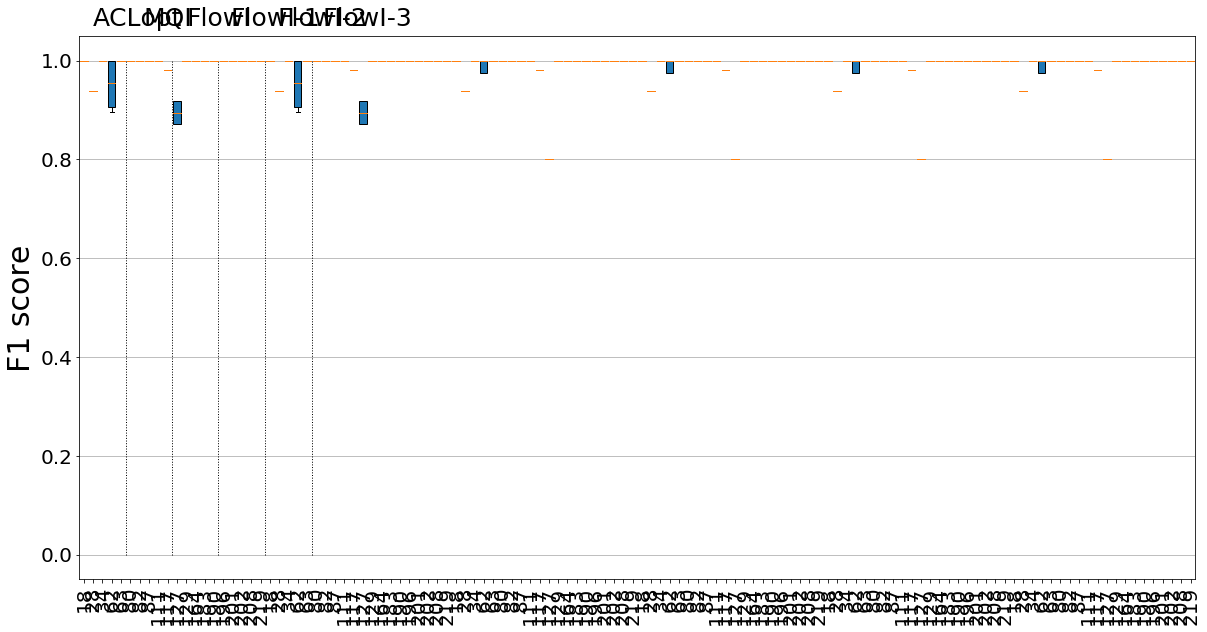

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_Optimal.png')

plt.show()

## Generate scatter plot for precision

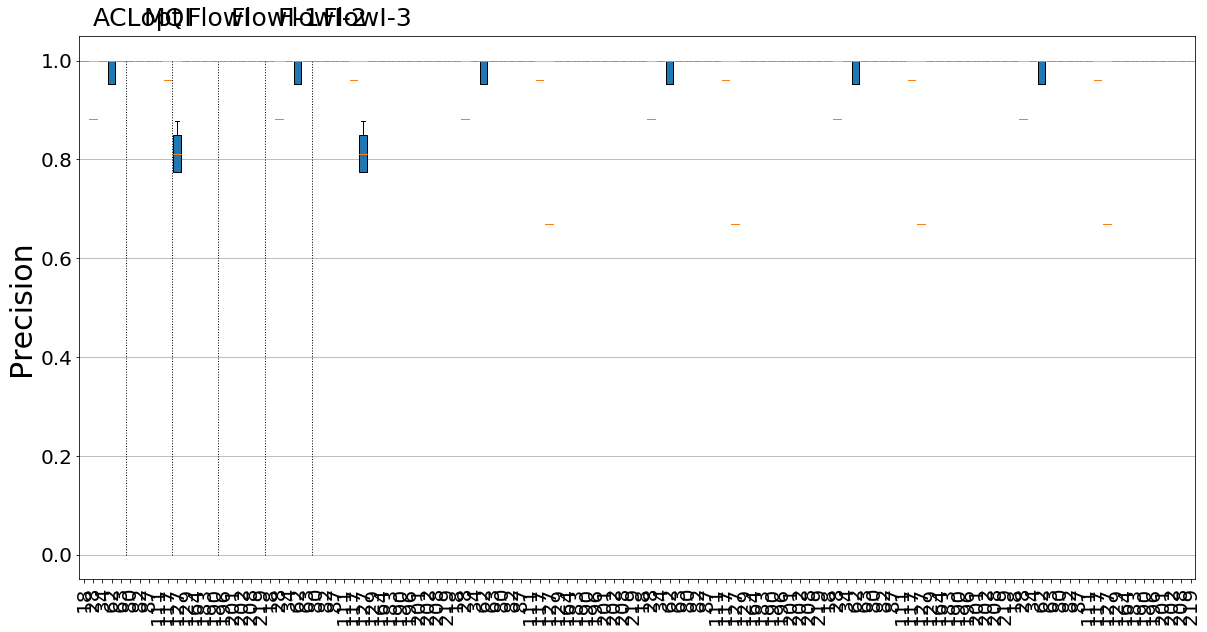

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_Optimal.png')

plt.show()

## Generate scatter plot for recall

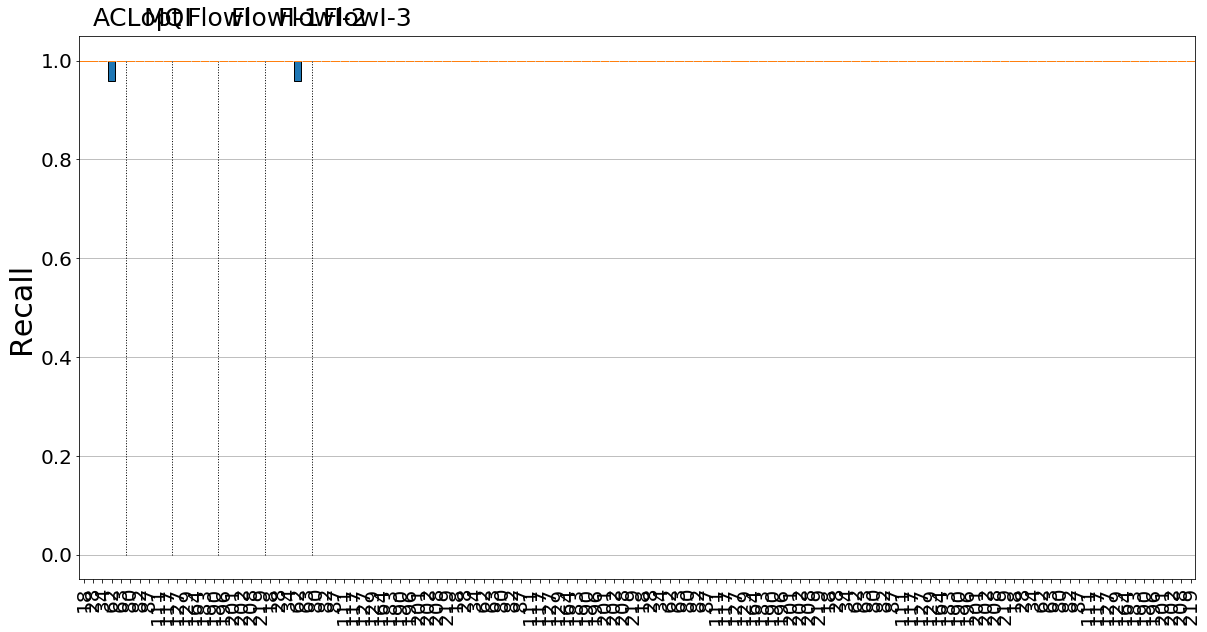

In [18]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])
        temp_conductance.append(external_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")
    
print('Results for MQIopt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        temp_conductance.append(external_cond_best_acl_flow_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowIopt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        temp_conductance.append(external_cond_best_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-1opt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
        temp_conductance.append(external_cond_best_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-2opt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        temp_conductance.append(external_cond_best_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

print('Results for FlowI-3opt')
sum_precision = 0
sum_recall = 0
sum_f1 = 0
sum_conductance = 0
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    temp_conductance = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        temp_conductance.append(external_cond_best_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1), 'Cond.', stat_.median(temp_conductance))    
    sum_precision += stat_.median(temp_pre)
    sum_recall += stat_.median(temp_rec)
    sum_f1 += stat_.median(temp_f1)
    sum_conductance += stat_.median(temp_conductance)
    
avg_precision = sum_precision/l_info_ref_nodes
avg_recall = sum_recall/l_info_ref_nodes
avg_f1 = sum_f1/l_info_ref_nodes
avg_conductance = sum_conductance/l_info_ref_nodes
    
print('Average precision', avg_precision, 'Average recall', avg_recall, 'Average F1', avg_f1, 'Av. Cond.', avg_conductance)
print(" ")

Results for ACLopt
Feature: 18.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 28.0 Precision 0.8824087245139877 Recall 1.0 F1 0.9375314861460956 Cond. 0.3333333333333333
Feature: 34.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 62.0 Precision 1.0 Recall 1.0 F1 0.955026455026455 Cond. 0.4330708661417323
Feature: 63.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 80.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 82.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 87.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 111.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 117.0 Precision 0.9613259668508287 Recall 1.0 F1 0.9802816901408451 Cond. 0.3370165745856354
Feature: 127.0 Precision 0.8107960741548528 Recall 1.0 F1 0.8945511479055452 Cond. 0.3808532778355879
Feature: 129.0 Precision 1.0 Recall 1.0 F1 1.0 Cond. 0.3333333333333333
Feature: 164.0 Precis